# This notebook is used to get the fine tissue segmentation

### It assumes we have all of the annotation and fold masks (aligned at level 0 dapi) and the multi-channel 20x magnification (level 1 h&e) core h&e images

In [1]:
import shapely
from shapely.geometry import Polygon

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2geojson import find_geocontours, export_annotations
import json
from glob import glob
from skimage.transform import resize
from PIL import Image
import tqdm

In [3]:
# Dictionary to get the h&e slide names from the xenium output name
anno_dict = {
    'output-XETG00206__0060075__Region_1__20250213__202651': 'ag_hpv_01',
    'output-XETG00206__0060077__Region_1__20250213__202651': 'ag_hpv_02',
    'output-XETG00206__0060354__Region_1__20250224__233922': 'ag_hpv_04',
    'output-XETG00206__0060367__Region_1__20250224__233922': 'ag_hpv_03',
    'output-XETG00403__0059911__Region_1__20250304__005817': 'ag_hpv_06',
    'output-XETG00403__0060395__Region_1__20250304__005817': 'ag_hpv_05',
    'output-XETG00206__0060364__Region_1__20250305__223715': 'ag_hpv_08',
    'output-XETG00206__0060366__Region_1__20250305__223715': 'ag_hpv_07',
    'output-XETG00206__0060488__Region_1__20250312__004017': 'ag_hpv_09',
    'output-XETG00206__0060493__Region_1__20250312__004017': 'ag_hpv_10'
}

In [4]:
LEVEL=0
pix_size =0.2125 * (2**LEVEL) # dapi pixel size

In [ ]:
# Read in annotation masks (as np arrays)
foldmasks = glob('/common/lamt2/HPV/data/xenium/alignment_v2/annotations/*foldmask.npy')
annots = glob('/common/lamt2/HPV/data/xenium/alignment_v2/annotations/*annot1.npy')

In [ ]:
# Get all unique batches (cores) from masks
batches = list(set([x.split('/')[-1].replace('_annot1.npy', '') for x in annots] + [x.split('/')[-1].replace('_foldmask.npy', '') for x in foldmasks]))

In [ ]:
# Loop over batches to get geojson for each core
for batch in tqdm.tqdm(batches, mininterval = 10, maxinterval = 60):
    slide = batch.split('___')[0]
    core = batch.split('___')[1]

    # Get background annotation and fold masks for the given batch
    f_annots = [x for x in annots if f'{batch}_annot1.npy' in x] 
    f_folds = [x for x in foldmasks if f'{batch}_foldmask.npy' in x]
    
    # Read in aligned core image (20x magnification)
    img_arr = np.asarray(Image.open(f'/common/knottsilab/xenium/hpv/aligned_cores/{anno_dict[slide]}/{anno_dict[slide]}___{core}.png'))

    # Get background mask and resize to match aligned image
    annot_mask = np.sum([np.load(f) for f in f_annots], axis = 0)
    annot_mask = resize(annot_mask, (img_arr.shape[0], img_arr.shape[1]), anti_aliasing=0)
    
    # Convert to bitmask (0 or 255 values only) and create the geocontours
    annot_bitmask = (annot_mask == 0).astype(np.uint8) * 255
    annot_geocontours = find_geocontours(annot_bitmask, mode = 'imagej')

    # Add background annotation contours to geojson
    features = []
    features.extend(c.export_feature(label = f'tissue') for c in annot_geocontours)
    
    # If a fold mask exists, repeat the above process and add mask to the geojson
    if len(f_folds) > 0:
        fold_mask = np.sum([np.load(f) for f in f_folds], axis = 0)
        fold_mask = resize(fold_mask, (img_arr.shape[0], img_arr.shape[1]), anti_aliasing=0)
        
        fold_bitmask = (fold_mask != 0).astype(np.uint8) * 255
        fold_geocontours = find_geocontours(fold_bitmask, mode = 'imagej')
        features.extend(c.export_feature(label = f'fold') for c in fold_geocontours)

    # Export geojson segmentation file
    export_annotations(features, f"/common/lamt2/HPV/data/foundation_models/segmentation/{anno_dict[slide]}___{core}.geojson")


100%|██████████| 804/804 [33:31<00:00,  2.50s/it]


# This is just to test if the masks make sense

In [ ]:
# Read in geojson
jf = '/common/lamt2/HPV/data/foundation_models/segmentation/ag_hpv_09___38.geojson'
data = json.load(open(jf))

In [6]:
from collections import defaultdict

In [ ]:
# For each feature type (tissue or fold) add the segmentation
masks = defaultdict(Polygon)
for feat in data['features']:
    coords = feat['geometry']['coordinates']
    for coord in coords:
        feat_mask = Polygon(coord)
        masks[feat['properties']['classification']['name']] = masks[feat['properties']['classification']['name']].union(feat_mask)

In [ ]:
# Aligned core image
img = Image.open('/common/knottsilab/xenium/hpv/aligned_cores/ag_hpv_09/ag_hpv_09___38.png')

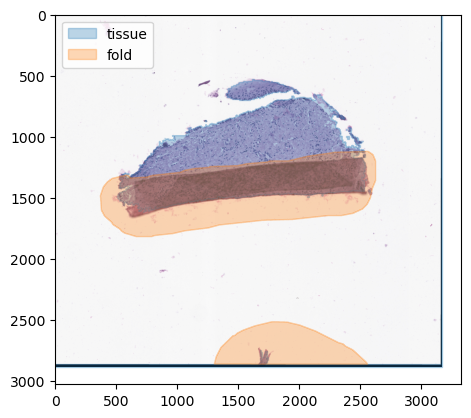

In [ ]:
# Plot core image and overlay feature segmentation
plt.imshow(img)
palette = {
    'tissue': 'C0',
    'fold': 'C1'}
for c in masks:
    for geo in masks[c].geoms:
        plt.fill(*geo.exterior.xy, alpha = 0.3, color = palette[c], label = c)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())